In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer, util
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shivani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shivani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shivani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
MODEL_PATH = "saved_model/"
try:
    model = SentenceTransformer(MODEL_PATH)
    print("Loaded model from saved path.")
except:
    model = SentenceTransformer("all-mpnet-base-v2")
    model.save(MODEL_PATH)
    print("Downloaded and saved model.")

Loaded model from saved path.


In [3]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return " ".join(words)

In [4]:
def rank_sentences(text, processed_sentences, original_sentences):
    sentence_scores = {}
    text_embedding = model.encode(text, convert_to_tensor=True)

    for i, sentence in enumerate(processed_sentences):
        sentence_embedding = model.encode(sentence, convert_to_tensor=True)
        similarity = util.pytorch_cos_sim(sentence_embedding, text_embedding).item()
        sentence_scores[original_sentences[i]] = similarity

    ranked_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)
    return ranked_sentences

In [5]:
def retrieve_top_sentences(text, top_k=3, ensure_diversity=True, diversity_threshold=0.5):
    original_sentences = sent_tokenize(text)
    processed_sentences = [preprocess_text(sentence) for sentence in original_sentences]

    if top_k > len(processed_sentences):
        top_k = len(processed_sentences)

    ranked_sentences = rank_sentences(text, processed_sentences, original_sentences)

    if ensure_diversity:
        selected_sentences = []
        embeddings = [model.encode(sent, convert_to_tensor=True) for sent in ranked_sentences]

        for i, sent in enumerate(ranked_sentences):
            if len(selected_sentences) == 0:
                selected_sentences.append(sent)
            else:
                is_diverse = True
                current_embedding = embeddings[i]

                for selected_sent in selected_sentences:
                    selected_embedding = model.encode(selected_sent, convert_to_tensor=True)
                    similarity = util.pytorch_cos_sim(current_embedding, selected_embedding).item()
                    if similarity > diversity_threshold:
                        is_diverse = False
                        break

                if is_diverse:
                    selected_sentences.append(sent)

            if len(selected_sentences) == top_k:
                break
        return selected_sentences
    else:
        return ranked_sentences[:top_k]

In [6]:
def generate_summary(text, summary_length=5, ensure_diversity=True, diversity_threshold=0.7):
    if not text.strip():
        return ""
    
    summary_sentences = retrieve_top_sentences(text, top_k=summary_length,
                                               ensure_diversity=ensure_diversity,
                                               diversity_threshold=diversity_threshold)
    
    original_sentences = sent_tokenize(text)
    ordered_summary = [sent for sent in original_sentences if sent in summary_sentences]
    
    return ' '.join(ordered_summary)

In [7]:
def calculate_accuracy(generated_summary, reference_summary, model_name="sentence-transformers/all-mpnet-base-v2"):
    model = SentenceTransformer(model_name)  
    
    generated_embedding = model.encode(generated_summary, convert_to_tensor=True)
    reference_embedding = model.encode(reference_summary, convert_to_tensor=True)
    
    similarity = util.pytorch_cos_sim(generated_embedding, reference_embedding).item()
    
    return similarity

In [8]:
def calculate_metrics(generated_summary, reference_summary):
    true_positives = sum(1 for word in generated_summary if word in reference_summary)
    false_positives = sum(1 for word in generated_summary if word not in reference_summary)
    false_negatives = sum(1 for word in reference_summary if word not in generated_summary)
    
    total_samples = true_positives + false_positives + false_negatives
    
    y_true = [1] * true_positives + [0] * (total_samples - true_positives)
    y_pred = [1] * true_positives + [1] * false_positives + [0] * false_negatives
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return precision, recall, f1 ,y_true,y_pred

In [9]:
text = """
Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural intelligence displayed by humans and animals. Leading AI textbooks define the field as the study of "intelligent agents": any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals. Colloquially, the term "artificial intelligence" is often used to describe machines that mimic cognitive functions that humans associate with the human mind, such as learning and problem-solving. As machines become increasingly capable, tasks considered to require "intelligence" are often removed from the definition of AI, a phenomenon known as the AI effect. A quip in Tesler's Theorem says "AI is whatever hasn't been done yet." For instance, optical character recognition is frequently excluded from things considered to be AI, having become a routine technology.
"""

reference_summary = "AI demonstrates intelligence by machines, contrasting human intelligence. It is defined as the study of intelligent agents that maximize their chances of achieving goals. The term is often used to describe machines mimicking cognitive functions like learning and problem-solving. As machines improve, tasks requiring intelligence are often redefined, known as the AI effect. Optical character recognition is an example of a technology that has become routine and is no longer considered AI."


In [10]:
summary_length = 3
summary = generate_summary(text, summary_length=summary_length, ensure_diversity=True, diversity_threshold=0.5)
print("\nGenerated Summary:\n", summary)


Generated Summary:
 Colloquially, the term "artificial intelligence" is often used to describe machines that mimic cognitive functions that humans associate with the human mind, such as learning and problem-solving. A quip in Tesler's Theorem says "AI is whatever hasn't been done yet." For instance, optical character recognition is frequently excluded from things considered to be AI, having become a routine technology.


In [11]:
accuracy = calculate_accuracy(summary, reference_summary)
print("Accuracy (Cosine Similarity):", accuracy)


Accuracy (Cosine Similarity): 0.8113909959793091


In [12]:
precision, recall, f1,y_true,y_pred = calculate_metrics(summary, reference_summary)
print("\nPrecision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))



Precision: 0.9801
Recall: 1.0000
F1 Score: 0.9899


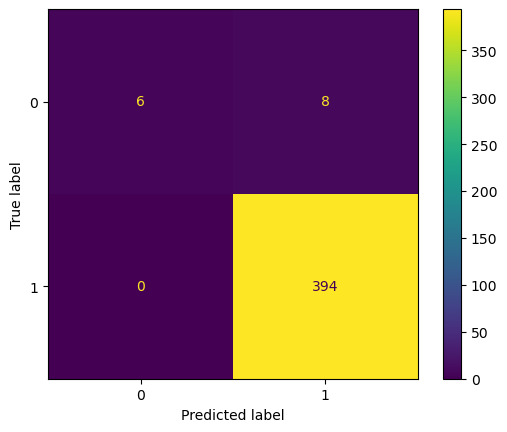

In [13]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()